# Predicting used car prices with linear regression

We will try to predict the price of a used car using a dataset found in Kaggle: https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes

This dataset includes close to 100,000 used cars sold in the UK from nine manufacturers. We will attempt to build a linear regression that is statistically sound by ensuring all regressions assumptions are met and verified.

Before we start we'll go over the key assumptions as a recap.

1. There should exist a linear relationship between the indepedent variables and dependent variable.
2. There should be little to no multicollinearity. This means there should be little or no correlations between independent variables.
3. No correlation between residual terms. There should exist no correlations between the error terms.
4. Signs of homoskedasticity. This simply means the error terms have constant variance.
5. Error terms should be normally distributed

In [1]:
import os
os.chdir('/Users/akashjalil/Documents/Kaggle files/Used car prices/Datasets')
import pandas as pd
import seaborn as sns
sns.set_style(style="darkgrid")
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def GetData():
    files = []
    for file in ['bmw.csv','audi.csv','merc.csv']:
        data_file = pd.read_csv(file)
        data_file['manufacturer'] = file.split('.')[0].capitalize()

        files.append(data_file)
    
    data = pd.concat(files, sort = False)
    data = data.apply(pd.to_numeric, errors = 'ignore')
    # Drop any additional columns with all nulls
    data = data.dropna(how = 'all', axis = 1)
    # Drop any rows with all nulls in the row
    data = data.dropna(how = 'all', axis = 0)
    # Drop duplicate rows
    data = data.drop_duplicates()
    
    # Remove white in front of model name
    data['model'] = data['model'].str.lstrip()
    data = data.reset_index(drop = True)
    
    return data[['manufacturer','model','year','price','transmission','mileage','fuelType','tax','mpg','engineSize']]

data = GetData()
data.head()

,manufacturer,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Bmw,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,Bmw,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,Bmw,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,Bmw,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,Bmw,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


The manufacturer and model names are not going to be important variables for us when building a linear regression. It would be like trying to estimate a person's age using their first and last name, it's not feasible. So for that reason we'll drop them and consider all the remaining 7 variables as our inputs. We'll do this at a later stage incase we need to do some immutation on our data.

In [3]:
#data = data.drop(['manufacturer','model'], axis = 1)

In [4]:
data.describe().round(2)

,year,price,mileage,tax,mpg,engineSize
count,34089.00,34089.00,34089.0,34089.00,34089.00,34089.00
mean,2017.15,23476.00,24141.0,129.17,54.25,2.06
std,2.25,11726.05,23199.8,64.99,21.31,0.58
min,1970.00,650.00,1.0,0.00,1.10,0.00
25%,2016.00,15980.00,6000.0,125.00,44.10,1.60
50%,2017.00,20995.00,17527.0,145.00,53.30,2.00
75%,2019.00,28170.00,35228.0,145.00,62.80,2.10
max,2020.00,159999.00,323000.0,580.00,470.80,6.60


We can see majority of the the cars being registered between 2016 and 2019. There does seem to be a few cars that have distinguising features such as a very high price, very high mileage, and also a car with an almost unrealistic mpg. We'll find these cars and decide whether to remove them as they could have input errors.

The transmission and fuelType columns are categorical so we'll see how many different combinations we get from these

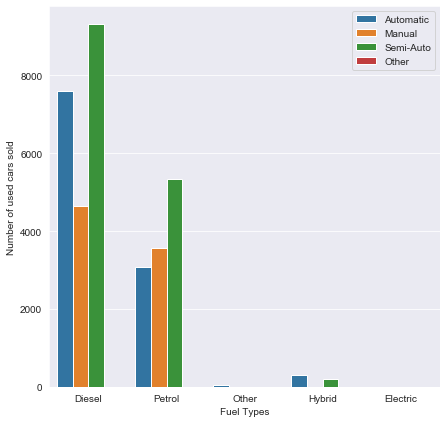

In [5]:
plt.figure(figsize=(7,7))
ax = sns.countplot(x = 'fuelType', data = data, hue = 'transmission')
plt.xlabel('Fuel Types')
plt.ylabel('Number of used cars sold')
plt.legend(loc = 'upper right')
plt.show()

We can see a very small number of vehicles sold having "other" as transmission. As these only total 9 out of 97,712 it's safe to remove these and not worry about why there is an "other" entry as one of the transmission choices.

In [6]:
data = data[data.transmission != 'Other']

Furthermore, we note how "Other" and "Electric" fuel types are disproportionality represented as well. Hybrid, although has a few entries for automatic used cars, they seem to be such a small fraction compared to Petrol and Diesel. Let's confirm the actual numbers below before deciding if we should eliminate them.

In [7]:
def CountTable(by):
    type_count = data.groupby(by).size().reset_index(name = 'Count')
    type_count['Percentage'] = round(type_count['Count']/data.shape[0],4)
    return type_count

CountTable('fuelType')

,fuelType,Count,Percentage
0,Diesel,21558,0.6324
1,Electric,3,0.0001
2,Hybrid,495,0.0145
3,Other,42,0.0012
4,Petrol,11989,0.3517


All together Electric, Hybrid, and Other fuel types make up less than 2% of the data. We could, if we really wanted to, is reduce the number of Diesel and Petrol cars in the dataset through random sampling so they roughly matched the number of Hybrids but that would reduce the total number of rows in the data considerably. We could randomly over sampling the Hybrid cars but that could lead to overfitting as we would have to over sample quite a lot. So, we will remove Electric, Hybrid, and Other fuel type cars from the dataset and focus on Petrol and Diesel only cars.

We will also omit any cars that have an engine size of 0 as our data will now only contain petrol and diesel cars.

In [8]:
data = data[data.fuelType.isin(['Petrol','Diesel'])]
data = data[data['engineSize'] > 0]

We know from above there is a car with mileage over 300,000. This seems quite high so we'll check to see how many other extreme mileaged cars there are in the dataset and remove them if they make up a small fraction.

In [9]:
CountTable(pd.cut(data.mileage,10))

,mileage,Count,Percentage
0,"(-321.999, 32300.9]",24002,0.7171
1,"(32300.9, 64600.8]",7247,0.2165
2,"(64600.8, 96900.7]",1834,0.0548
3,"(96900.7, 129200.6]",322,0.0096
4,"(129200.6, 161500.5]",54,0.0016
5,"(161500.5, 193800.4]",9,0.0003
6,"(193800.4, 226100.3]",1,0.0000
7,"(226100.3, 258400.2]",1,0.0000
8,"(258400.2, 290700.1]",1,0.0000
9,"(290700.1, 323000.0]",1,0.0000


Less than 1% of cars have a mileage greater than 129,000 miles. This is likely skewing the mileage column to the right and we should remove these as it can have a detriment effect to our linear regression and clearly these values are outliers in our dataset.

In [10]:
data = data[data.mileage < 129200.6]

We have a variable for registration year which is labeled as an int but should be a categorical input. We should group these into a bucket of ranges. We'll observe a table and cumulative plot to decide how to bucket the years

In [11]:
year_count = CountTable('year')
year_count['Cumulative sum'] = year_count['Count'].cumsum()
year_count['Cumulative percentage'] = year_count['Percentage'].cumsum()
year_count

,year,Count,Percentage,Cumulative sum,Cumulative percentage
0,1996,1,0.0000,1,0.0000
1,1997,3,0.0001,4,0.0001
2,1998,6,0.0002,10,0.0003
3,1999,5,0.0001,15,0.0004
4,2000,5,0.0001,20,0.0005
5,2001,12,0.0004,32,0.0009
6,2002,16,0.0005,48,0.0014
7,2003,14,0.0004,62,0.0018
8,2004,27,0.0008,89,0.0026
9,2005,20,0.0006,109,0.0032


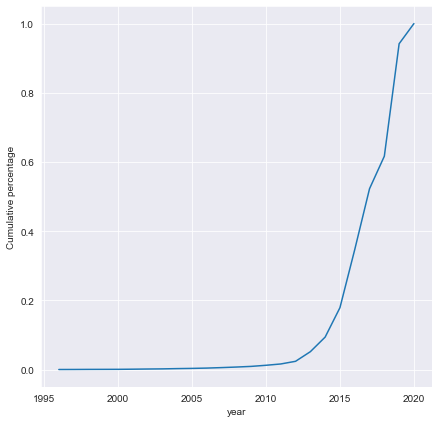

In [12]:
plt.figure(figsize=(7,7))
sns.lineplot(x = 'year', y = 'Cumulative percentage', data = year_count)
plt.show()

We see that our data is comprised of very modern cars. Cars registered before 2018 make up 52% of the data so we'll have a new column which tells us whether the car was registered before or after 2018. This column will roughly even werighted with the number of cars in it.

In [13]:
def BucketYear(year):
    if year <= 2015:
        return 'before 2016'
    return str(year)
data['year_group'] = data['year'].apply(lambda x: BucketYear(x))
data = data.drop('year',axis = 1)

In [14]:
data.head()

,manufacturer,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,year_group
0,Bmw,5 Series,11200,Automatic,67068,Diesel,125,57.6,2.0,before 2016
1,Bmw,6 Series,27000,Automatic,14827,Petrol,145,42.8,2.0,2018
2,Bmw,5 Series,16000,Automatic,62794,Diesel,160,51.4,3.0,2016
3,Bmw,1 Series,12750,Automatic,26676,Diesel,145,72.4,1.5,2017
4,Bmw,7 Series,14500,Automatic,39554,Diesel,160,50.4,3.0,before 2016


Let's now visualise our data and try to understand what how things relate. We'll start off with a simple correlation matrix for all numerical variables and then do a pairwise scatterplot coloured by year_group, transmission, and fueltype.

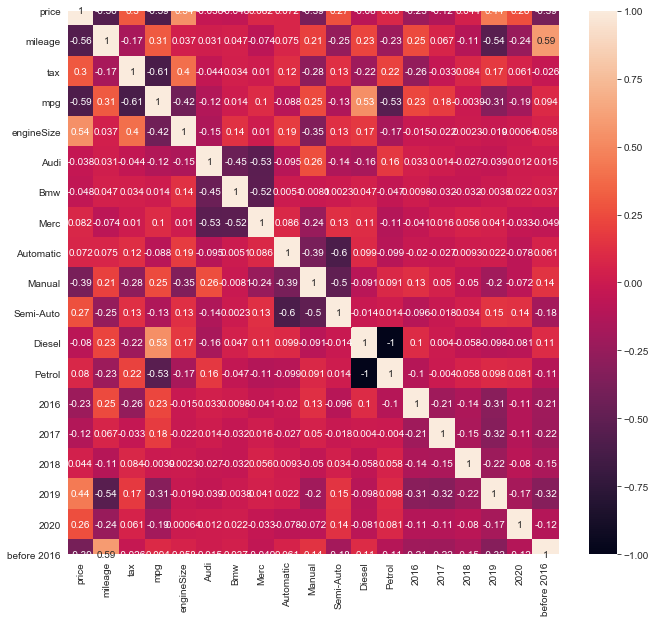

In [15]:
def CorrelationMatrix():
    df = data.copy()
    dummy_dfs = []
    # One hot encoding the categorical variables into binary so we can compute the correlation
    for col in ['manufacturer','transmission','fuelType','year_group']:
        dummy_dfs.append(pd.get_dummies(df[col]))
    
    df = pd.concat([df] + dummy_dfs, axis = 1)
    df = df.drop(['manufacturer','transmission','fuelType','year_group'], axis = 1)
        
    plt.figure(figsize=(11,10))
    sns.heatmap(df.corr(), annot = True)
    plt.show()
    
CorrelationMatrix()

In this correlation matrix we have one hot encoded our categorical variables (transmission, fueltype, and year_group) into binary columns representing each of the different values in that column. The most noticable correlation we see is between petrol and diesel. This is expected as we've reduced our dataset down to only petrol and diesel cars. We will only be taking one of these variables in our data input table as there's no need for both.

One concern we can see is the high correlation between mileage and after / before 2018 (+- 0.67). We will have to either remove mileage or the binary year indicators.

Moreover, we can also see high negative correlation between mpg and tax. This is natural as lower mpg cars, such as performance cars, will have a higher road tax attached to them. This again is a multicollinearity issue and should be looked into before creating an linear regression. We will use a technique called variance inflation factor to decide which of these variables to keep.  

We also notice enginesize is positively correlated with price. Again this would be expected as a car with a bigger displacement would be told at a premium compared to smaller engine cars. Another variable which can be considered slightly highly correlated with price is manual tranmission. Thinking about this makes sense as most modern cars, and cars with larger engines, come with an automatic transmission and are likely to be more expensive than manual transmissions.

MPG and mileage are moderately negatively correlated with price. We would expect this as higher mileage cars fetch lower prices and cars with low MPG are going to go for a higher price. 

/Users/akashjalil/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


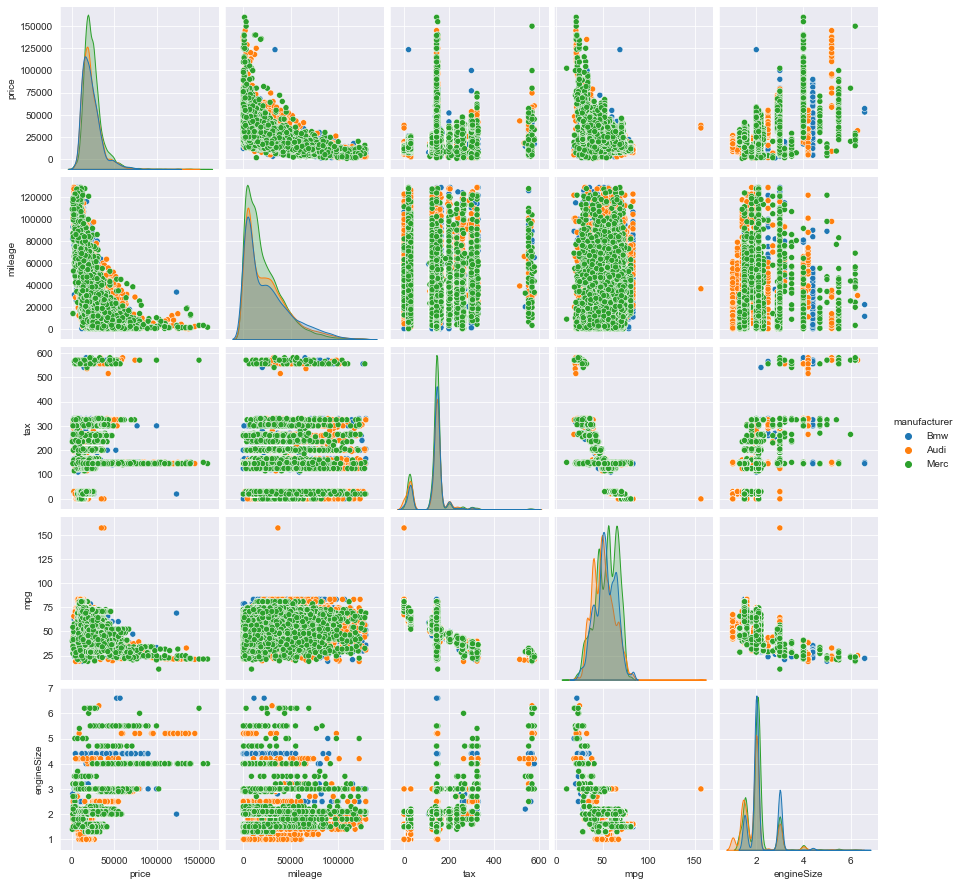

In [16]:
def PairPlot(hue):
    sns.pairplot(data, hue)
    plt.show()

PairPlot('manufacturer')

The first thing we see is how right skewed price and mileage are in the dataset. We should pay attention to the residuals of price in model evaluation as we require normality which would tell us whether we should tranform prices. Not surprisingly, the mileage for cars in 2020 are very low which explains the tall brown peak in mileage. Although it is difficult to see we can identify some linearity with price for mileage, tax, and mpg.

Another interesting observation is with the mpg column. There are some cars with very high mpg values. We might need to investigate these as our dataset now only contains petrol and diesel engines which should not have very low or very high mpg values.

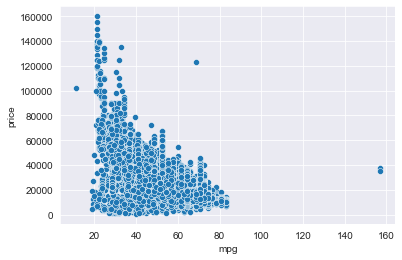

In [17]:
sns.scatterplot(x = 'mpg', y = 'price', data= data)
plt.show()

In [18]:
data.nlargest(5,'mpg')

,manufacturer,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,year_group
16261,Audi,Q7,37999,Automatic,36461,Diesel,0,156.9,3.0,2016
16573,Audi,Q7,34999,Semi-Auto,36461,Diesel,0,156.9,3.0,2016
23,Bmw,1 Series,9400,Manual,44498,Diesel,0,83.1,1.5,2016
48,Bmw,1 Series,9200,Manual,48858,Diesel,0,83.1,1.5,2016
59,Bmw,1 Series,11100,Manual,11524,Diesel,0,83.1,1.5,before 2016


There are two data points with very high mpgs. We see these are both Audi Q7s. A quick google search shows these vehicles as having a hybrid / electric types which can produce those high mpgs. We removed all hybrid and electric types before so these were most likely incorrectly inputted. We'll just remove these easily so that our range of mpg is more acceptable.

In [19]:
data = data[~data.index.isin(data[data['mpg'] > 100].index)]
data.nlargest(5,'mpg')

,manufacturer,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,year_group
23,Bmw,1 Series,9400,Manual,44498,Diesel,0,83.1,1.5,2016
48,Bmw,1 Series,9200,Manual,48858,Diesel,0,83.1,1.5,2016
59,Bmw,1 Series,11100,Manual,11524,Diesel,0,83.1,1.5,before 2016
98,Bmw,1 Series,11400,Manual,26265,Diesel,0,83.1,1.5,2017
134,Bmw,1 Series,8000,Manual,81579,Diesel,0,83.1,1.5,2016


Our data looks good to now start building a base linear regression model. We just need transform the three categorical variables into one hot encoded columns before we split the data into training and testing sets and remove variables with high multicollinearity. 

In [20]:
def OneHotEncodingDF():
    df = data.copy()
    dummy_dfs = []
    # One hot encoding the categorical variables into binary so we can compute the correlation
    for col in ['manufacturer','transmission','fuelType','year_group']:
        dummy_dfs.append(pd.get_dummies(df[col]))
    
    df = pd.concat([df] + dummy_dfs, axis = 1)
    df = df.drop(['manufacturer','model','transmission','fuelType','year_group','Diesel','Automatic','Bmw','before 2016'], axis = 1)
    
    return df

transformed_data = OneHotEncodingDF()

In [21]:
transformed_data.head()

,price,mileage,tax,mpg,engineSize,Audi,Merc,Manual,Semi-Auto,Petrol,2016,2017,2018,2019,2020
0,11200,67068,125,57.6,2.0,0,0,0,0,0,0,0,0,0,0
1,27000,14827,145,42.8,2.0,0,0,0,0,1,0,0,1,0,0
2,16000,62794,160,51.4,3.0,0,0,0,0,0,1,0,0,0,0
3,12750,26676,145,72.4,1.5,0,0,0,0,0,0,1,0,0,0
4,14500,39554,160,50.4,3.0,0,0,0,0,0,0,0,0,0,0


We've removed the model column from the dataset as we're not trying to build predictive model based on distinct car names. There are 11 new columns on the right which only contain 0 and 1 to indicate if a car has that property. Furthermore, we've removed the diesel heading as that would be the opposite of petrol and does provide any additional information. Similarly, we remove Automatic as when Petrol and Semi-Auto are 0 then this indicates the car is Automatic. We've removed Bmw as we have identifiers for Audi and Mercedes already.

In [22]:
X = transformed_data.drop('price', axis = 1)
Y = transformed_data['price']
Y = np.log(Y)

We've also logged the price and mileage of each car. This is to change the distribution from right skewed to a more normal distribution. See the comparions below.

/Users/akashjalil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()
/Users/akashjalil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


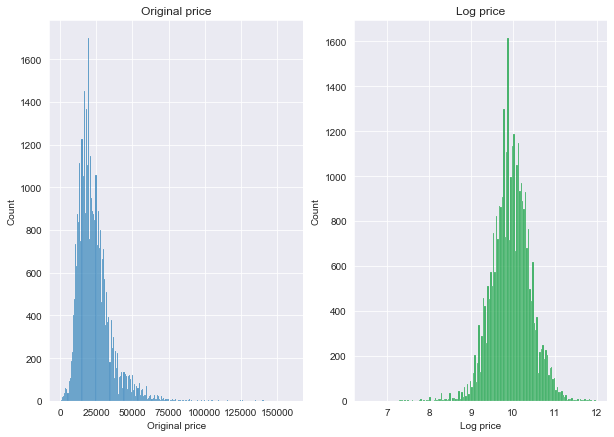

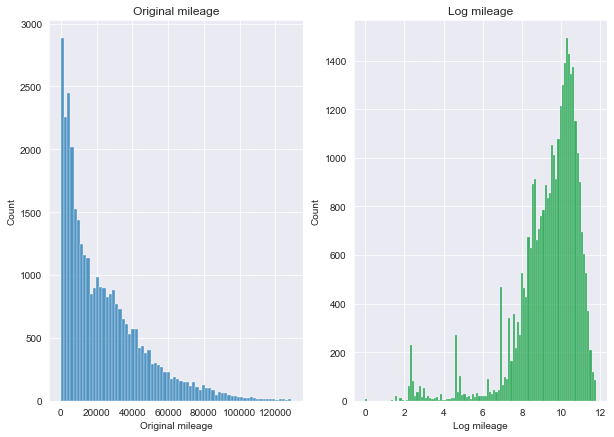

In [23]:
def OriginalToLogPlots(column):
    fig, ax = plt.subplots(1,2,figsize=(10,7))
    ax1 = sns.histplot(data = data, x = column, ax = ax[0])
    ax1.set_title(f'Original {column}')
    ax1.set_xlabel(f'Original {column}')

    ax2 = sns.histplot(np.log(data[column]), ax = ax[1], color = '#009933')
    ax2.set_title(f'Log {column}')
    ax2.set_xlabel(f'Log {column}')

    fig.show()

OriginalToLogPlots('price')

OriginalToLogPlots('mileage')

The price has definitely been transformed correctly to a much nicer distribution which is resembles a normal. However, this is definitely now a more fat tailed which might cause issues when we fit a linear regression model and assess the normality of residuals

Mileage on the other hand has gone from a right skewed distribution to a left skewed distribution so the log transformation may not be the best for this variable. We can try using the Box Cox transformation which is a popular technique.

/Users/akashjalil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


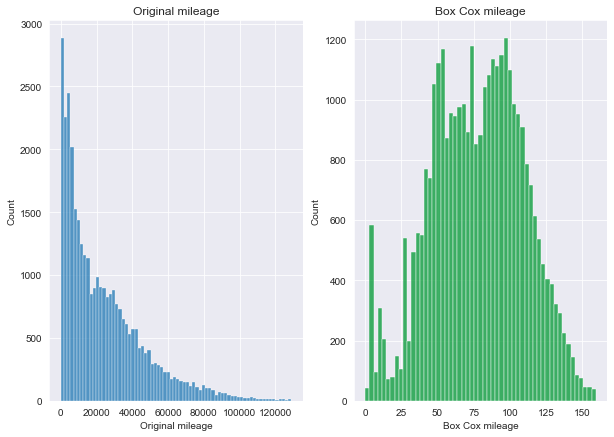

In [24]:
from scipy import stats
def BoxCoxTransformation(column = 'mileage'):
    box_cox_values = stats.boxcox(data[column])[0]
    
    fig, ax = plt.subplots(1,2,figsize=(10,7))
    ax1 = sns.histplot(data = data, x = column, ax = ax[0])
    ax1.set_title(f'Original {column}')
    ax1.set_xlabel(f'Original {column}')

    ax2 = sns.histplot(box_cox_values, ax = ax[1], color = '#009933')
    ax2.set_title(f'Box Cox {column}')
    ax2.set_xlabel(f'Box Cox {column}')

    fig.show()

BoxCoxTransformation()

The transformation looks much better than the log transformation. Although not perfectly normal, it's definitely a good enough transformation.

/Users/akashjalil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


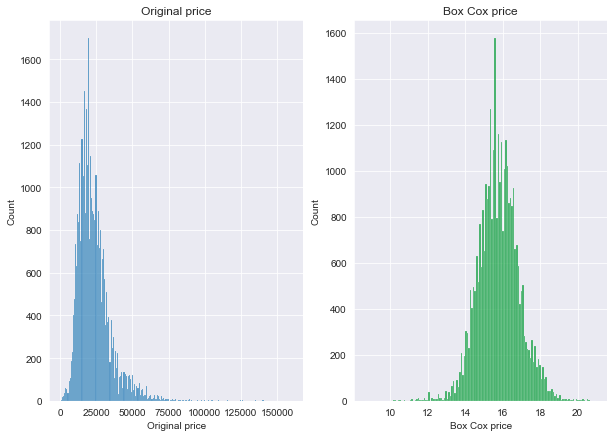

In [25]:
BoxCoxTransformation(column = 'price')

In [26]:
X['mileage'] = stats.boxcox(X['mileage'])[0]

To remove explanatory variables with high correlation between each other we will use a statistical method called variance inflation factor (VIF) which will fit a OLS (ordinary least squares) regression to variable with the remaining variables. Then compute the VIF using $\frac{1}{1 - R^2}$. If the VIF > 10 then multicollinearity is high and this variable should be removed.

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
def CalculateVIF(X):
    vif_df = pd.DataFrame()
    vif_df['Features'] = X.columns
    vif_df['VIF'] = [vif(X.values, index) for index in range(len(X.columns))]
    
    return vif_df

vif_1 = CalculateVIF(X)
vif_1

,Features,VIF
0,mileage,20.350855
1,tax,7.792897
2,mpg,24.756529
3,engineSize,15.202390
4,Audi,2.077135
5,Merc,2.284134
6,Manual,2.243705
7,Semi-Auto,2.475122
8,Petrol,2.030658
9,2016,2.070886


We see mpg has the highest VIF value of 24.76 and this should be removed. We'll run the VIF multiple times and drop any variables with a vif above 10.

In [28]:
def MultiVIFRun(X):
    data = X.copy()
    columns = data.columns.tolist()
    for _ in columns:
        vifs = [vif(data[columns].values, index) for index in range(len(columns))]
        max_vif, column = max(vifs), columns[vifs.index(max(vifs))]
        
        if max_vif >= 10:
            print(f'Highest VIF is {max_vif} for {column}')
            columns.remove(column)
        else:
            break
    
    
    return CalculateVIF(data[columns])

vif_2 = MultiVIFRun(X)
vif_2

Highest VIF is 24.756529030691116 for mpg
Highest VIF is 15.15757182104586 for engineSize


,Features,VIF
0,mileage,6.194290
1,tax,5.663725
2,Audi,2.075339
3,Merc,2.200894
4,Manual,1.979405
5,Semi-Auto,2.393690
6,Petrol,1.793882
7,2016,1.702300
8,2017,1.737189
9,2018,1.441567


In [29]:
# new_X is basically our X dataframe with all explanatory variables but with high VIF variables removed
new_X = X[vif_2['Features'].values]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_X, Y, test_size = 0.33, random_state = 1)

Now we'll build the first OLS linear regression model and evaluate the p-values for each variable as well as do some diagnostic plots to test the assumptions listed at the start.

In [30]:
import statsmodels.api as sm
# For our constant (C) variable in Y = C + m_1x_1 + ... + m_nx_n we add a column full of 1s at the start
X_train.insert(0,'const',1)
# Train our OLS model with our training set
model = sm.OLS(y_train,X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     3655.
Date:                Mon, 04 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:21:13   Log-Likelihood:                -2426.8
No. Observations:               22380   AIC:                             4880.
Df Residuals:                   22367   BIC:                             4984.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0139      0.014    714.851      0.000       9.986      10.041
mileage       -0.0057      0.000    -54.002      0.000      -0.006      -0.005
tax            0.0011   3.12e-05     34.666      0.000       0.001       0.001
Audi           0.0943      0.005     20.058      0.000       0.085       0.103
Merc           0.0428      0.004      9.669      0.000       0.034       0.052
Manual        -0.2800      0.005    -52.760      0.000      -0.290      -0.270
Semi-Auto      0.0254      0.004      5.957      0.000       0.017       0.034
Petrol        -0.0730      0.004    -17.940      0.000      -0.081      -0.065
2016           0.2448      0.006     38.300      0.000       0.232       0.257
2017           0.2852      0.007     43.384      0.000       0.272       0.298
2018           0.3383      0.008     39.937      0.000       0.322       0.355
2019           0.4078      0.009     47.814      0.000       0.391       0.425
2020           0.4501      0.012     36.582      0.000       0.426       0.474
==============================================================================
Omnibus:                     2861.587   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35207.320
Skew:                          -0.015   Prob(JB):                         0.00
Kurtosis:                       9.145   Cond. No.                     1.80e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There's quite a bit to unpack so we'll go through each heading in the output. We know that R-squared represents the proportion of variance in the dependent variable (price) that is explained by the indepedent variables (mileage, tax, ...). This is 0.662 which although less than the 0.7 standard of good fit is not that bad. The F-Statistic is the statistic used to compute the hypothesis of an F-test. The F-test in this case tests the global significance of our model and whether it's better than a model with no predictors. The Prob(F-statistic) is less than the significance level of 0.05 so this a good news.

In the next section the coef (coefficient) is simply the value of each coefficient in our linear regression formula. The best way to interpret this is when there is an increase in one unit of a variable, with the rest remaining the same, then the value of our depedent value increases by the coefficient value.

Standard error can be interpreted as average standard deviation of the estimated coefficient. The smaller, the better as a small standard deviation implies higher precision.

The t statistic is the estimated coefficient / standard error. This is the number of standard deviations the estimated coefficient is away from 0. The higher the value the better as we can reject the null hypothesis of there being no relationship between the dependent and independent variable. 

P > |t| is the p-value associated with the t statistic. That is, the probability of observing any value larger than or equal to t. We compare this to the 5% significant level and if the p-value is less than this we can assume the variable is significant in our model. All variables are significant.

Now importantly we need to check the diagnostic plots of our regression model and ensure the models works well and fits the data. This a step usually skipped by *'ML people'*. $R^2$ is not an adequate measure and only gives us a small glimpse into the overall fit of an OLS model. To check diagnostic plot we will emulate the plot function in from $R$, the code for this was taken from https://emredjan.github.io/blog/2017/07/11/emulating-r-plots-in-python/.

/Users/akashjalil/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


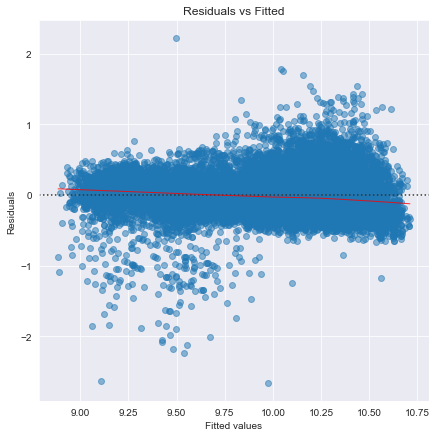

In [32]:
# Fitted values (Predicted values from our model)
model_fitted_y = model.fittedvalues

# Model residuals (Actual values - predicted values)
model_residuals = model.resid

# Normalized residuals
model_norm_residuals = model.get_influence().resid_studentized_internal

# Absolute residuals
model_abs_resid = np.abs(model_residuals)

# Absolute square root normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(model_abs_resid)

# Cook's distance
model_cooks = model.get_influence().cooks_distance[0]

def ResidualPlot(model,y_train):
    model_fitted_y = model.fittedvalues
    plt.figure(figsize=(7,7))
    plot = sns.residplot(model_fitted_y, y_train,lowess=True,
                                      scatter_kws={'alpha': 0.5},
                                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    
    plot.axes.set_title('Residuals vs Fitted')
    plot.axes.set_xlabel('Fitted values')
    plot.axes.set_ylabel('Residuals')
    plt.show()

ResidualPlot(model,y_train)

The residual vs fitted values plot allows us to assess linearity and homoskedasticity. We are looking to see if there is a non linear pattern with our residuals. If this is the case then we would know there exists a non linear relationship. In our case there is no non linear pattern which is good.

However, for homoskedasticity we are looking for residuals to be evenly spread around 0 mean. In our case there are points in the lower and higher end of our fitted values with low and high residuals respectively. Thus they are equally spread around the mean. Let's check the scale location plot which is another way of assessing homoskedasticity.

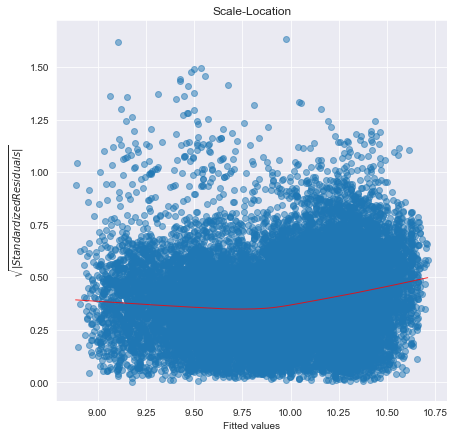

In [33]:
def ScaleLocationPlot(model):
    model_fitted_y = model.fittedvalues
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model.resid))
    plt.figure(figsize=(7,7))
    plot = plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
                scatter=False, 
                ci=False, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot.axes.set_title('Scale-Location')
    plot.axes.set_xlabel('Fitted values')
    plot.axes.set_ylabel('$\sqrt{|Standardized Residuals|}$')
    plt.show()

ScaleLocationPlot(model)

The scale location plot is similar to the residuals vs fitted values plot above however in this case we take the square of the standardised residuals. We want to check that the red line, representing a regression line modelled on the fitted values and standard residuals, is approximately straight horizontal. In this it is not, as for higher fitted values it increases. We also want to check the spread of the points and approximately evenly spread. It fails both of these checks as there are clearly points with much higher residual values.

We can clearly see our model is not able to meet the homoskedasticity assumption we need. Let's check the QQ plot to see if our residuals are normally distributed.

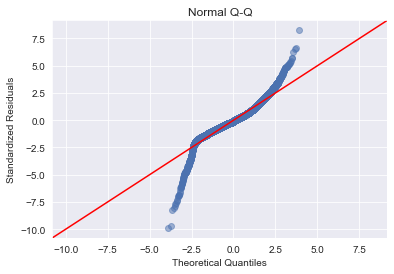

In [45]:
from statsmodels.graphics.gofplots import ProbPlot
def QQPlot(model):
    model_norm_residuals = model.get_influence().resid_studentized_internal
    QQ = ProbPlot(model_norm_residuals)
    plot = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
        
    plot.axes[0].set_title('Normal Q-Q')
    plot.axes[0].set_xlabel('Theoretical Quantiles')
    plot.axes[0].set_ylabel('Standardized Residuals')
    plt.show()

QQPlot(model)

The QQ plot is used to assess whether the residuals are normally distributed. If they were they would sit on or close to the red line. In our case, some points do lie on the red line but there are extreme tails which indicate there exists extreme residuals on the tails. It seems our distribution might be more of a cauchy distribution. 

For extreme values we can look into the cook's distance. The cook's distance is a measure of influence for each residual. They indicate how much a residual has an overall impact on the accuracy of the model. The higher the influence the more impact it has. It is computed by measuring the change in the regression model when a given point is removed. The general rule of thumb is if the cooks distance for a residual is greater than 3 x the mean of cook distances then this is an extreme value and should be removed.

/Users/akashjalil/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


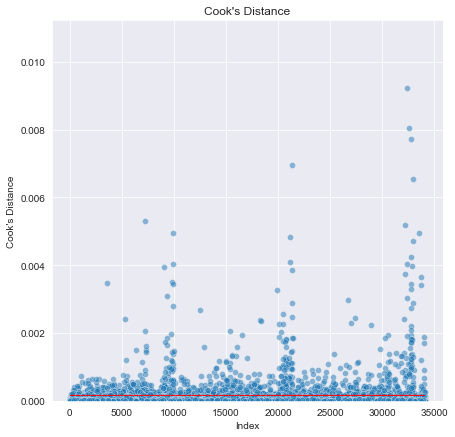

Number of outliers: 1262


In [40]:
def CooksDistancePlot(model, X_train):
    model_cooks = model.get_influence().cooks_distance[0]
    cook_distance_mean = np.mean(model_cooks)
    max_cooks_distance = np.full(X_train.shape[0],3*cook_distance_mean) 
    plt.figure(figsize = (7,7))
    plot = sns.scatterplot(X_train.index, model_cooks, alpha = 0.5)
    plt.plot(X_train.index,max_cooks_distance,lw=1, ls='--', color='red')
    
    plot.axes.set_title('Cook\'s Distance')
    plot.axes.set_ylim(0,np.max(model_cooks) + 0.002)
    plot.axes.set_xlabel('Index')
    plot.axes.set_ylabel('Cook\'s Distance')
    plt.show()
    
    print('Number of outliers: %s' %len(model_cooks[model_cooks > 3*cook_distance_mean]))

CooksDistancePlot(model,X_train)

The red line is the value of 3 x cooks distance mean and we can see there are 1,262 residuals that fit above this line. We will remove these values, retrain our model, and look at the diagnostic plots again.

In [50]:
def RemoveCookOutliers(model, X_train, y_train):
    model_cooks = model.get_influence().cooks_distance[0]
    cook_distance_mean = np.mean(model_cooks)
    
    index_of_outliers = np.where(model_cooks > 3*cook_distance_mean)[0]
    
    y_train = y_train.reset_index(drop = True)
    y_train = y_train[~y_train.index.isin(index_of_outliers)]
    
    X_train = X_train.reset_index(drop = True)
    X_train = X_train[~X_train.index.isin(index_of_outliers)]
    
    return X_train, y_train

X_train_wo_outliers, y_train_wo_outliers = RemoveCookOutliers(model, X_train, y_train)

In [51]:
model_wo_outliers = sm.OLS(y_train_wo_outliers, X_train_wo_outliers).fit()
model_wo_outliers.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     5482.
Date:                Mon, 04 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:54:00   Log-Likelihood:                 4153.4
No. Observations:               21118   AIC:                            -8281.
Df Residuals:                   21105   BIC:                            -8177.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9088      0.011    910.449      0.000       9.887       9.930
mileage       -0.0048   8.17e-05    -59.026      0.000      -0.005      -0.005
tax            0.0015   2.68e-05     54.151      0.000       0.001       0.002
Audi           0.0867      0.004     24.265      0.000       0.080       0.094
Merc           0.0531      0.003     15.747      0.000       0.046       0.060
Manual        -0.2363      0.004    -58.841      0.000      -0.244      -0.228
Semi-Auto      0.0254      0.003      7.799      0.000       0.019       0.032
Petrol        -0.0861      0.003    -27.639      0.000      -0.092      -0.080
2016           0.2110      0.005     43.931      0.000       0.202       0.220
2017           0.2411      0.005     48.456      0.000       0.231       0.251
2018           0.2694      0.007     41.286      0.000       0.257       0.282
2019           0.3904      0.007     59.870      0.000       0.378       0.403
2020           0.4301      0.010     44.491      0.000       0.411       0.449
==============================================================================
Omnibus:                      502.097   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              546.958
Skew:                           0.367   Prob(JB):                    1.70e-119
Kurtosis:                       3.287   Cond. No.                     1.76e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All of our variables are still significant with low p-values and most noticably the $R^2$ has jumped from 0.66 to 0.76 which a good improvement. Let's check the diagnostic plots again and hope we can see signs of homoskedasticity and normality for our residuals.

/Users/akashjalil/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


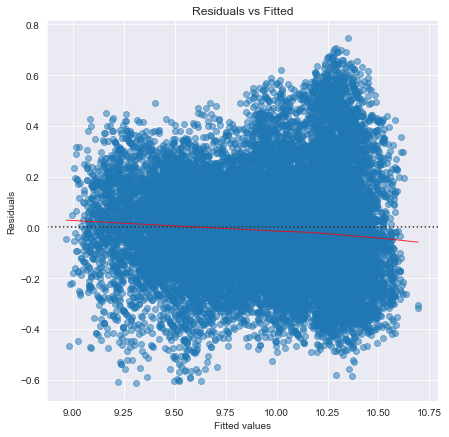

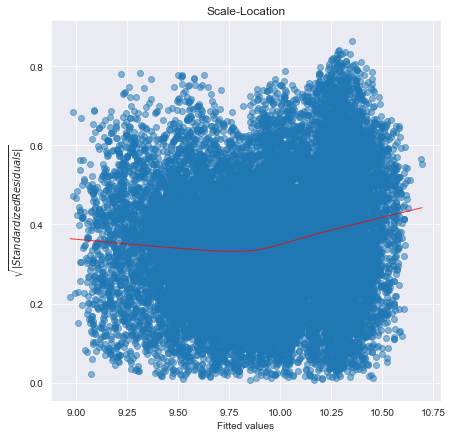

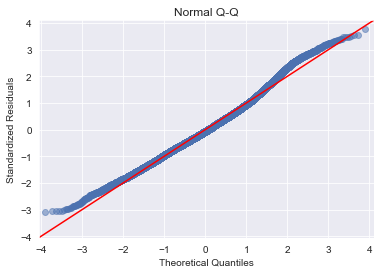

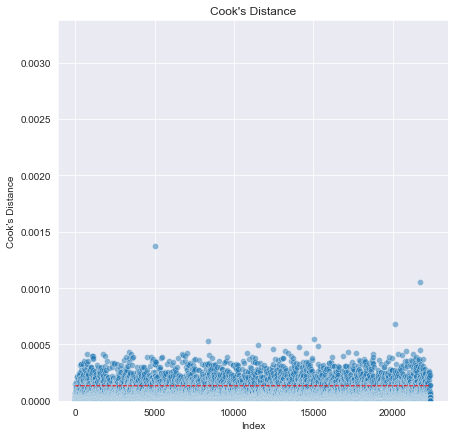

Number of outliers: 1994


In [52]:
# Diagnostic plots
ResidualPlot(model_wo_outliers, y_train_wo_outliers)
ScaleLocationPlot(model_wo_outliers)
QQPlot(model_wo_outliers)
CooksDistancePlot(model_wo_outliers, X_train_wo_outliers)

There is definitely an improvement by removing those 1,262 outliers. The residual vs fitted values plot nows shows a nice spread around 0 and the red line does not deviate much from the y = 0 line which tells us that our assumption of linearity is reasonable. Also, the spread of the residuals is not extreme, although there are points away from 0 they are almost symmetrical so we can assume no outliers are present. We can also argue there seems to be equal variance as well due to the semi even spread.

In the scale location plot we see the removal of a cluster of residuals that were deviating away from the majority. This is good and we again see a reasonable spread.

The QQ plot has improved considerable and the points lie very close to the normal line. Although there is some deviation near the ends of the line, this is very natural as is seen in many datasets. The vast majority are on the red line so we can assume our residuals are normally distributed.

The cooks distance plot does show there might be additionally outliers but with such a large dataset, that has a large range of car prices, we can argue until the end of times there exists an outlier in our data. We've been able to satisfy our regression assumptions.

We saved a test dataset which we will now draw some accuracy metrics before training some machine learning models to compare. The metrics we will use are:

* $R^2$ - How well the model fits the data
* Root Mean Square Error (RMSE) - This is a good metric to use as it punishes outliers when there is a large difference between actual and predicted. The squaring prevents the cancellation of positive and negative errors.
* Mean Absolute Error (MAE) - Measures the average absolute difference between actual and predicted. Less sensitive to outliers
* Mean Absolute Percentage Error (MAPE) - Measures the average percentage difference between actual and predicted

In [57]:
from statsmodels.tools.eval_measures import rmse

def rsquared(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    sse = np.sum(np.square(actual - predicted))
    
    ssy = np.sum(np.square(actual - np.mean(actual)))
    
    return 1 - (sse/ssy)

def mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted)/actual))*100

In [62]:
predicted = model_wo_outliers.fittedvalues
lm_rmse = rmse(y_train_wo_outliers,predicted)
lm_mae = mae(y_train_wo_outliers,predicted)
lm_mape = mape(y_train_wo_outliers,predicted)
lm_r2 = rsquared(y_train_wo_outliers,predicted)

results = pd.DataFrame({'Model': 'Linear Regression',
                        'R2': lm_r2,
                        'RMSE': lm_rmse,
                        'MAE': lm_mae,
                        'MAPE': lm_mape}, index = [0])
results

,Model,R2,RMSE,MAE,MAPE
0,Linear Regression,0.757098,0.198768,0.155691,1.559104
